In [6]:
from Levenshtein import editops # To track actions for transpositions
from nltk import edit_distance # For Damerau–Levenshtein distance

import os

from denovo_utils.data import Run
from denovo_utils.parsers import DenovoEngineConverter
from denovo_utils.io.read import load_psmlist

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from denovo_utils.analysis.metrics import load_seq_score_dicts
from denovo_utils.analysis.metrics import get_match_score_table, get_prc_curve

from psm_utils import Peptidoform
from tqdm import tqdm
from peak_pack.utils import calculate_ppm

from denovo_utils.analysis.metrics import (
    get_refinement_error_tables,
    plot_refinement_error_table,
    plot_precision_recall_refinement
)

# 1. Read in the data

In [7]:
mapper = {
    "[+25.980265]-": "b",
    "[UNIMOD:1]-": "a",
    "[UNIMOD:5]-": "d",
    "[UNIMOD:385]-": "e",
    "Q[UNIMOD:7]": "q",
    "N[UNIMOD:7]": "n",
    "C[UNIMOD:4]": "c",
    "M[UNIMOD:35]": 'm',
    "S[UNIMOD:21]": 's',
    "T[UNIMOD:21]": 't',
    "Y[UNIMOD:21]": 'y',
    "L": "I"
}

def peptidoform_to_lstring(peptidoform, mapper):
    new_peptidoform = peptidoform.proforma
    for p, l in mapper.items():
        new_peptidoform = new_peptidoform.replace(p, l)
    return new_peptidoform.split('/')[0]

peptidoform_to_lstring(
    Peptidoform('[UNIMOD:385]-ADC[UNIMOD:4]DK/2'),
    mapper=mapper
)

'eADcDK'

In [ ]:
# root_results_dn = '/public/compomics3/Sam/PXD028735/QExactive/denovo_output'
# root_mgf = '/public/compomics3/Sam/PXD028735/QExactive/mgf_reformatted'
# root_results_db = '/public/compomics3/Sam/PXD028735/QExactive/search_results/identification'

root_rescoring = '/public/compomics3/Sam/PXD028735/QExactive/rescoring'

run_names = [
    'LFQ_Orbitrap_DDA_Ecoli_01',
    'LFQ_Orbitrap_DDA_Human_01',
    'LFQ_Orbitrap_DDA_QC_01',
    'LFQ_Orbitrap_DDA_Yeast_01'
]

engine_names = [
    'adanovo',
    'pihelixnovo',
    'piprimenovo',
    'casanovo',
    'instanovo',
    'contranovo',
    'novob',
    'pepnet',
]

refinement_names = [
    'spectralis',
    'instanovoplus'
]

runs = {}
for run_name in run_names:
    print(f"Run: {run_name}")
    run = Run(run_name)

    gt_path = os.path.join(root_rescoring, run_name, 'psmlist', 'ground_truth.parquet')
    psmlist_gt = load_psmlist(gt_path)
    run.load_data(
        psmlist=psmlist_gt.get_rank1_psms(),
        score_names=['score_ms2rescore'],
        is_ground_truth=True
    )

    for engine_name in engine_names:
        print(f'loading {engine_name}')

        denovo_path = os.path.join(root_rescoring, run_name, 'psmlist', f'{engine_name}.parquet')
        psmlist_denovo = load_psmlist(denovo_path)
        run.load_data(
            psmlist=psmlist_denovo,
            score_names=['score_ms2rescore'],
            is_ground_truth=False
        )
    
        # load refinement
        for refinement_name in refinement_names:
            refinement_path = os.path.join(root_rescoring, run_name, 'psmlist', f'{engine_name}.{refinement_name}.parquet')
            if os.path.exists(refinement_path):
                print(f'    loading {refinement_name}')
                psmlist_refinement = load_psmlist(refinement_path)
                run.load_refinement(psmlist_refinement)

    runs[run_name] = run
    break

Run: LFQ_Orbitrap_DDA_Ecoli_01


100%|██████████| 24285/24285 [00:01<00:00, 21653.65it/s]


loading casanovo


100%|██████████| 61876/61876 [00:00<00:00, 126482.11it/s]


    loading spectralis


100%|██████████| 61876/61876 [00:09<00:00, 6866.11it/s]


    loading instanovoplus


100%|██████████| 61866/61866 [00:10<00:00, 5715.55it/s]


loading instanovo


100%|██████████| 61562/61562 [00:00<00:00, 81250.64it/s]


    loading spectralis


100%|██████████| 61562/61562 [00:08<00:00, 7106.76it/s]


    loading instanovoplus


100%|██████████| 61557/61557 [00:11<00:00, 5183.93it/s]


loading contranovo


100%|██████████| 30999/30999 [00:00<00:00, 69790.43it/s]


    loading spectralis


100%|██████████| 31017/31017 [00:04<00:00, 7138.34it/s]


    loading instanovoplus


100%|██████████| 31015/31015 [00:03<00:00, 8542.61it/s]


loading novob


100%|██████████| 61479/61479 [00:00<00:00, 82295.09it/s]


    loading spectralis


100%|██████████| 61479/61479 [00:08<00:00, 7159.78it/s]


    loading instanovoplus


100%|██████████| 61476/61476 [00:07<00:00, 8436.47it/s]


loading pepnet


100%|██████████| 62560/62560 [00:00<00:00, 81367.46it/s]


    loading spectralis


100%|██████████| 62559/62559 [00:14<00:00, 4249.75it/s]


    loading instanovoplus


100%|██████████| 62557/62557 [00:07<00:00, 8430.32it/s]


In [4]:
for run in runs.values():
    for spectrum in tqdm(run.spectra.values()):
        psm_gt = spectrum.psm_gt
        psm_gt.scores.add_score(
            score=psm_gt.scores.get_score('sage'),
            metadata='score_ms2rescore',
            score_type='peptide'
        )
        spectrum.compare_gt(
            metadata_score="score_ms2rescore"
        )
        spectrum.compare_gt(
            metadata_score="score_ms2rescore",
            refinements=['Spectralis', 'InstaNovo+']
        )

100%|██████████| 15982/15982 [00:43<00:00, 366.70it/s]


# 2. Calculate Levenshtein distance

In [5]:
levenshtein_df = []
for run in runs.values():

    for spectrum in tqdm(run.spectra.values()):
        psm_gt = spectrum.psm_gt
        peptidoform_gt = peptidoform_to_lstring(psm_gt.peptidoform, mapper=mapper)

        for psm_candidate in spectrum.psm_candidates:
            
            type_ = 'ignore'
            # Determine psm_type
            try:
                spectralis = psm_candidate.refinement['Spectralis']
            except:
                spectralis = False
            try:
                instanovoplus = psm_candidate.refinement['InstaNovo+']
            except:
                instanovoplus = False


            # FIRST FOR SPECTRALIS
            for refinement_made, refiner_name in zip([spectralis, instanovoplus], ['Spectralis', "InstaNovo+"]):
                if refinement_made:
                    # If the original was correct
                    if psm_candidate.evaluation['score_ms2rescore'].error_type == 'match':
                        # Yet got perturbed anyhow
                        if not refinement_made[1]: # refinement_made[1] == True if unperturbed
                            changes = editops(
                                peptidoform_gt,
                                peptidoform_to_lstring(refinement_made[0].peptidoform, mapper)
                            )
                            type_ = 'correct-perturbed'
                            
                            entry = {
                                'type': type_,
                                'engine': psm_candidate.engine_name,
                                'refiner': refiner_name,
                                'levenshtein_candidate': 0,
                                'levenshtein_refinement': len(changes),
                                'levenshtein_candidate_refinement': len(changes),
                                'changes': changes,
                                'ms2rescore_diff_gt_candidate': psm_gt.scores.get_score('score_ms2rescore') - psm_candidate.scores.get_score('score_ms2rescore'),
                                'ms2rescore_diff_candidate_refinement': psm_candidate.scores.get_score('score_ms2rescore') - refinement_made[0].scores.get_score('score_ms2rescore'),
                                'ms2rescore_diff_gt_refinement': psm_gt.scores.get_score('score_ms2rescore') - refinement_made[0].scores.get_score('score_ms2rescore')
                            }

                    # If the original was incorrect
                    if psm_candidate.evaluation['score_ms2rescore'].error_type != 'match':
                        # And remained unchanged
                        if refinement_made[1]:
                            changes = editops(
                                peptidoform_gt,
                                peptidoform_to_lstring(psm_candidate.peptidoform, mapper)
                            )
                            type_ = 'wrong-unperturbed'
                            entry = {
                                'type': type_,
                                'engine': psm_candidate.engine_name,
                                'refiner': refiner_name,
                                'levenshtein_candidate': len(changes),
                                'levenshtein_refinement': len(changes),
                                'levenshtein_candidate_refinement': 0,
                                'changes': [],
                                'ms2rescore_diff_gt_candidate': psm_gt.scores.get_score('score_ms2rescore') - psm_candidate.scores.get_score('score_ms2rescore'),
                                'ms2rescore_diff_candidate_refinement': 0,
                                'ms2rescore_diff_gt_refinement': psm_gt.scores.get_score('score_ms2rescore') - psm_candidate.scores.get_score('score_ms2rescore')
                            }

                        # And got corrected
                        elif refinement_made[0].evaluation['score_ms2rescore'].error_type == 'match':
                            changes = editops(
                                peptidoform_to_lstring(psm_candidate.peptidoform, mapper),
                                peptidoform_to_lstring(refinement_made[0].peptidoform, mapper)
                            )
                            type_ = 'corrected-by-refinement'
                            entry = {
                                'type': type_,
                                'engine': psm_candidate.engine_name,
                                'refiner': refiner_name,
                                'levenshtein_candidate': len(changes),
                                'levenshtein_refinement': len(changes),
                                'levenshtein_candidate_refinement': 0,
                                'changes': [],
                                'ms2rescore_diff_gt_candidate': psm_gt.scores.get_score('score_ms2rescore') - psm_candidate.scores.get_score('score_ms2rescore'),
                                'ms2rescore_diff_candidate_refinement': psm_candidate.scores.get_score('score_ms2rescore') - refinement_made[0].scores.get_score('score_ms2rescore'),
                                'ms2rescore_diff_gt_refinement': psm_gt.scores.get_score('score_ms2rescore') - refinement_made[0].scores.get_score('score_ms2rescore')
                            }
                        
                        # And remained incorrect
                        else:
                            type_ = 'wrong-wrong'
                            gt_candidate_distance = editops(
                                peptidoform_gt,
                                peptidoform_to_lstring(psm_candidate.peptidoform, mapper)
                            )
                            gt_refinement_distance = editops(
                                peptidoform_gt,
                                peptidoform_to_lstring(refinement_made[0].peptidoform, mapper)
                            )
                            candidate_refinement_distance = editops(
                                peptidoform_to_lstring(psm_candidate.peptidoform, mapper),
                                peptidoform_to_lstring(refinement_made[0].peptidoform, mapper),
                            )
                            entry = {
                                'type': type_,
                                'engine': psm_candidate.engine_name,
                                'refiner': refiner_name,
                                'levenshtein_candidate': len(gt_candidate_distance),
                                'levenshtein_refinement': len(gt_refinement_distance),
                                'levenshtein_candidate_refinement': len(candidate_refinement_distance),
                                'changes': candidate_refinement_distance,
                                'ms2rescore_diff_gt_candidate': psm_gt.scores.get_score('score_ms2rescore') - psm_candidate.scores.get_score('score_ms2rescore'),
                                'ms2rescore_diff_candidate_refinement': psm_candidate.scores.get_score('score_ms2rescore') - refinement_made[0].scores.get_score('score_ms2rescore'),
                                'ms2rescore_diff_gt_refinement': psm_gt.scores.get_score('score_ms2rescore') - refinement_made[0].scores.get_score('score_ms2rescore')
                            }
                    levenshtein_df.append(entry)
                else:
                    continue
                

  0%|          | 0/15982 [00:00<?, ?it/s]


NameError: name 'entry' is not defined

In [75]:
import pandas as pd

In [123]:
levenshtein_df = pd.DataFrame(levenshtein_df)

## 3. Show refinement types

Text(0.5, 1.0, 'InstaNovo+')

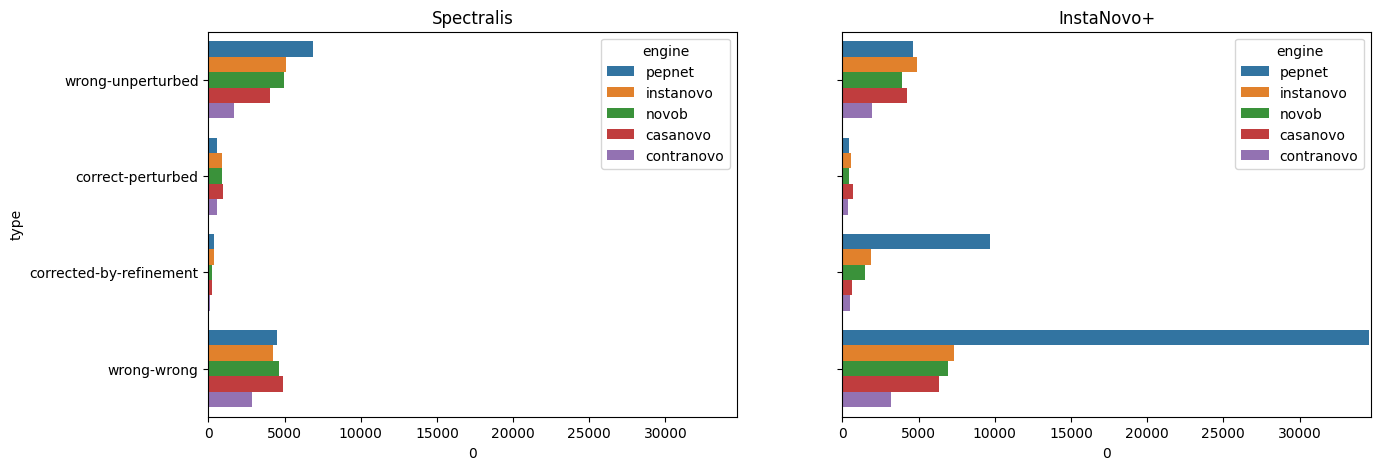

In [157]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,5))

scenario_order = ['wrong-unperturbed', 'correct-perturbed', 'corrected-by-refinement', 'wrong-wrong']

spectralis_counts = levenshtein_df[levenshtein_df['refiner']=='Spectralis'][['engine', 'type']].value_counts().reset_index()
instanovoplus_counts = levenshtein_df[levenshtein_df['refiner']=='InstaNovo+'][['engine', 'type']].value_counts().reset_index()
sns.barplot(
    spectralis_counts,
    x=0,
    y='type',
    hue='engine',
    ax=ax[0],
    order=scenario_order
)
sns.barplot(
    instanovoplus_counts,
    x=0,
    y='type',
    hue='engine',
    ax=ax[1],
    order=scenario_order
)

x_min = 0
x_max = max(spectralis_counts[0].max(), instanovoplus_counts[0].max())

# Set the x-axis range for both plots
ax[0].set_xlim(x_min, x_max+100)
ax[1].set_xlim(x_min, x_max+100)

ax[0].set_title('Spectralis')
ax[1].set_title('InstaNovo+')

In [153]:
spectralis_counts[0].max()

6886

In [146]:
levenshtein_df['refiner'].value_counts()

InstaNovo+    94635
Spectralis    49011
Name: refiner, dtype: int64

In [86]:
levenshtein_df.columns

Index(['type', 'engine', 'refiner', 'levenshtein_candidate',
       'levenshtein_refinement', 'levenshtein_candidate_refinement', 'changes',
       'ms2rescore_diff', 'ms2rescore_diff_candidate_refinement',
       'ms2rescore_diff_gt_refinement'],
      dtype='object')

In [101]:
levenshtein_df['type'].unique()

array(['wrong-wrong', 'wrong-unperturbed', 'corrected-by-refinement',
       'correct-perturbed'], dtype=object)

# 4. Plotting levenshtein distance distribution by refinement type

## 4.1 Levenshtein distance of all wrong de novo sequences

<Axes: xlabel='levenshtein_candidate', ylabel='percentage'>

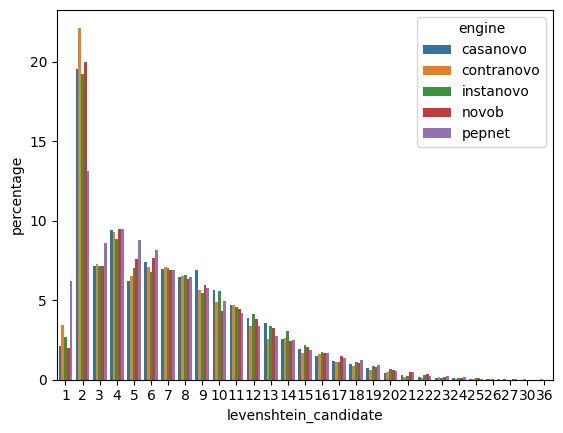

In [107]:
import seaborn as sns
import pandas as pd

# Filter the data
filtered_df = levenshtein_df.loc[
    (levenshtein_df['type'] != 'correct-perturbed') & (levenshtein_df['refiner'] == 'Spectralis'),
    ['engine', 'levenshtein_candidate']
]

# Calculate percentages by 'engine' (hue)
normalized_df = (
    filtered_df
    .groupby(['engine', 'levenshtein_candidate'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

# Create the normalized countplot
sns.barplot(
    data=normalized_df,
    x='levenshtein_candidate',
    y='percentage',
    hue='engine'
)


In [ ]:
# Filter the data
filtered_df_spectralis = levenshtein_df.loc[
    (levenshtein_df['type'] == 'wrong-unperturbed') & (levenshtein_df['refiner'] == 'Spectralis'),
    ['engine', 'levenshtein_candidate']
]
filtered_df_instanovoplus = levenshtein_df.loc[
    (levenshtein_df['type'] == 'wrong-unperturbed') & (levenshtein_df['refiner'] == 'InstaNovo+'),
    ['engine', 'levenshtein_candidate']
]

# Calculate percentages by 'engine' (hue)
normalized_df = (
    filtered_df
    .groupby(['engine', 'levenshtein_candidate'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

# Create the normalized countplot
sns.barplot(
    data=normalized_df,
    x='levenshtein_candidate',
    y='percentage',
    hue='engine'
)


## 4.2 Wrong and unperturbed PSMs

Text(0.5, 1.0, 'InstaNovo+')

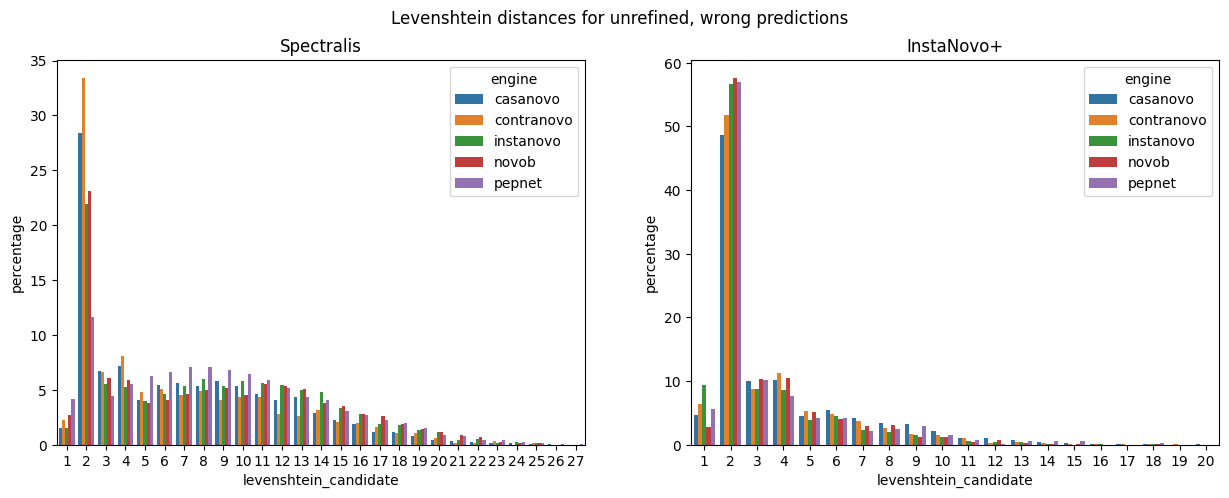

In [108]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# UNNORMALIZED BY HUE
# sns.countplot(
#     levenshtein_df.loc[
#         (levenshtein_df['type']=='wrong-unperturbed') & (levenshtein_df['refiner']=='Spectralis'),
#         ['engine', 'levenshtein_candidate']
#     ],
#     x='levenshtein_candidate',
#     hue='engine',
#     ax=ax[0]
# )
# sns.countplot(
#     levenshtein_df.loc[
#         (levenshtein_df['type']=='wrong-unperturbed') & (levenshtein_df['refiner']=='InstaNovo+'),
#         ['engine', 'levenshtein_candidate']
#     ],
#     x='levenshtein_candidate',
#     hue='engine',
#     ax=ax[1]
# )

# Filter the data
filtered_df_spectralis = levenshtein_df.loc[
    (levenshtein_df['type'] == 'wrong-unperturbed') & (levenshtein_df['refiner'] == 'Spectralis'),
    ['engine', 'levenshtein_candidate']
]
filtered_df_instanovoplus = levenshtein_df.loc[
    (levenshtein_df['type'] == 'wrong-unperturbed') & (levenshtein_df['refiner'] == 'InstaNovo+'),
    ['engine', 'levenshtein_candidate']
]

# Calculate percentages by 'engine' (hue)
normalized_df_spectralis = (
    filtered_df_spectralis
    .groupby(['engine', 'levenshtein_candidate'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)
normalized_df_instanovoplus = (
    filtered_df_instanovoplus
    .groupby(['engine', 'levenshtein_candidate'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

sns.barplot(
    data=normalized_df_spectralis,
    x='levenshtein_candidate',
    y='percentage',
    hue='engine',
    ax=ax[0]
)
sns.barplot(
    data=normalized_df_instanovoplus,
    x='levenshtein_candidate',
    y='percentage',
    hue='engine',
    ax=ax[1]
)

fig.suptitle('Levenshtein distances for unrefined, wrong predictions')
ax[0].set_title('Spectralis')
ax[1].set_title('InstaNovo+')

In [133]:
engine_order = [
    'casanovo',
    'novob',
    'instanovo',
    'contranovo',
    'pepnet'
]

In [144]:
# Define the desired order for the y-axis
engine_order = ['casanovo', 'novob', 'instanovo', 'contranovo', 'pepnet']

# Filter data for both refiners
def plot_boxplot_score_diff(df, refinement_type, score_label, xlabel='Score Ground-truth - Score de novo'):

    spectralis_data = df.loc[
        (df['type'] == refinement_type) & (df['refiner'] == 'Spectralis')
    ]
    instanovo_data = df.loc[
        (df['type'] == refinement_type) & (df['refiner'] == 'InstaNovo+')
    ]

    # Calculate the overall x-axis range
    x_min = min(spectralis_data[score_label].min(), instanovo_data[score_label].min())
    x_max = max(spectralis_data[score_label].max(), instanovo_data[score_label].max())

    # Create subplots
    fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

    # Plot for Spectralis
    sns.boxplot(
        data=spectralis_data,
        x=score_label,
        y='engine',
        order=engine_order,
        ax=ax[0]
    )

    # Plot for InstaNovo+
    sns.boxplot(
        data=instanovo_data,
        x=score_label,
        y='engine',
        order=engine_order,
        ax=ax[1]
    )

    # Set the x-axis range for both plots
    ax[0].set_xlim(x_min-.5, x_max+.5)
    ax[1].set_xlim(x_min-.5, x_max+.5)

    # Add labels and titles
    ax[0].set_title('Spectralis')
    ax[1].set_title('InstaNovo+')

    
    ax[0].set_xlabel(xlabel)
    ax[1].set_xlabel(xlabel)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

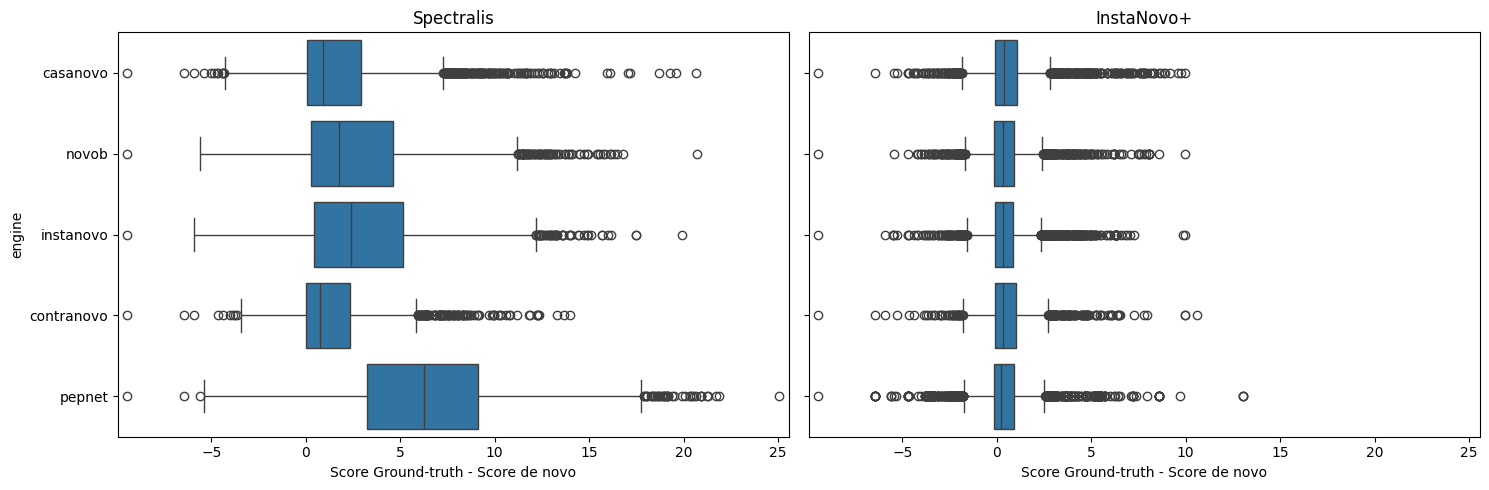

In [139]:
plot_boxplot_score_diff(
    df=levenshtein_df,
    refinement_type='wrong-unperturbed',
    score_label='ms2rescore_diff_gt_refinement'
)

## 4.3 Correct and falsely perturbed PSMs

Text(0.5, 1.0, 'InstaNovo+')

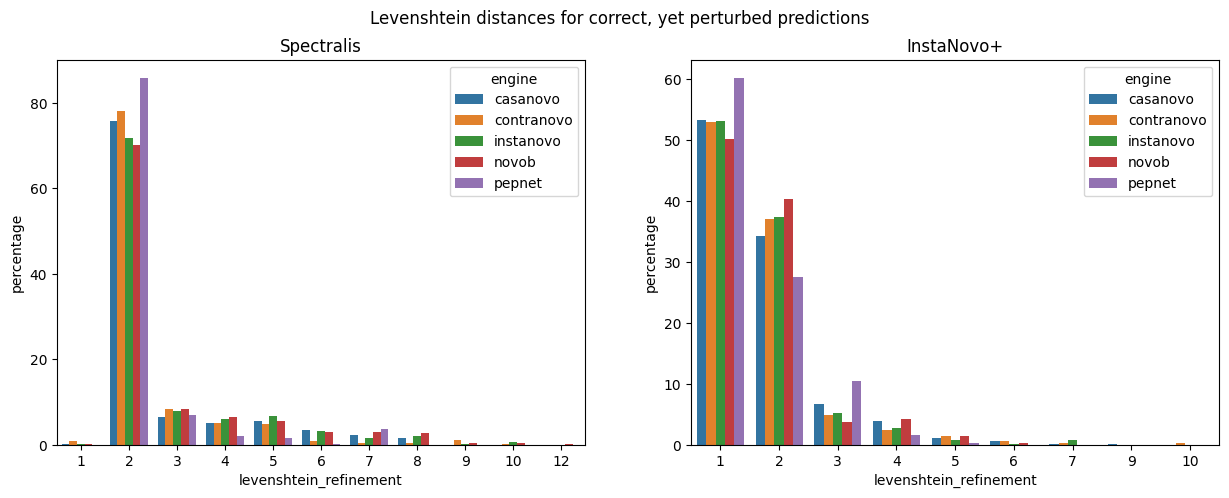

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# sns.countplot(
#     levenshtein_df.loc[
#         (levenshtein_df['type']=='correct-perturbed') & (levenshtein_df['refiner']=='Spectralis'),
#         ['engine', 'levenshtein_refinement']
#     ],
#     x='levenshtein_refinement',
#     hue='engine',
#     ax=ax[0]
# )
# sns.countplot(
#     levenshtein_df.loc[
#         (levenshtein_df['type']=='correct-perturbed') & (levenshtein_df['refiner']=='InstaNovo+'),
#         ['engine', 'levenshtein_refinement']
#     ],
#     x='levenshtein_refinement',
#     hue='engine',
#     ax=ax[1]
# )
# Filter and normalize data for 'Spectralis'
spectralis_df = levenshtein_df.loc[
    (levenshtein_df['type'] == 'correct-perturbed') & (levenshtein_df['refiner'] == 'Spectralis'),
    ['engine', 'levenshtein_refinement']
]
spectralis_normalized = (
    spectralis_df
    .groupby(['engine', 'levenshtein_refinement'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

# Filter and normalize data for 'InstaNovo+'
instanovo_df = levenshtein_df.loc[
    (levenshtein_df['type'] == 'correct-perturbed') & (levenshtein_df['refiner'] == 'InstaNovo+'),
    ['engine', 'levenshtein_refinement']
]
instanovo_normalized = (
    instanovo_df
    .groupby(['engine', 'levenshtein_refinement'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

# Create the first plot for 'Spectralis'
sns.barplot(
    data=spectralis_normalized,
    x='levenshtein_refinement',
    y='percentage',
    hue='engine',
    ax=ax[0]
)

# Create the second plot for 'InstaNovo+'
sns.barplot(
    data=instanovo_normalized,
    x='levenshtein_refinement',
    y='percentage',
    hue='engine',
    ax=ax[1]
)

fig.suptitle('Levenshtein distances for correct, yet perturbed predictions')
ax[0].set_title('Spectralis')
ax[1].set_title('InstaNovo+')

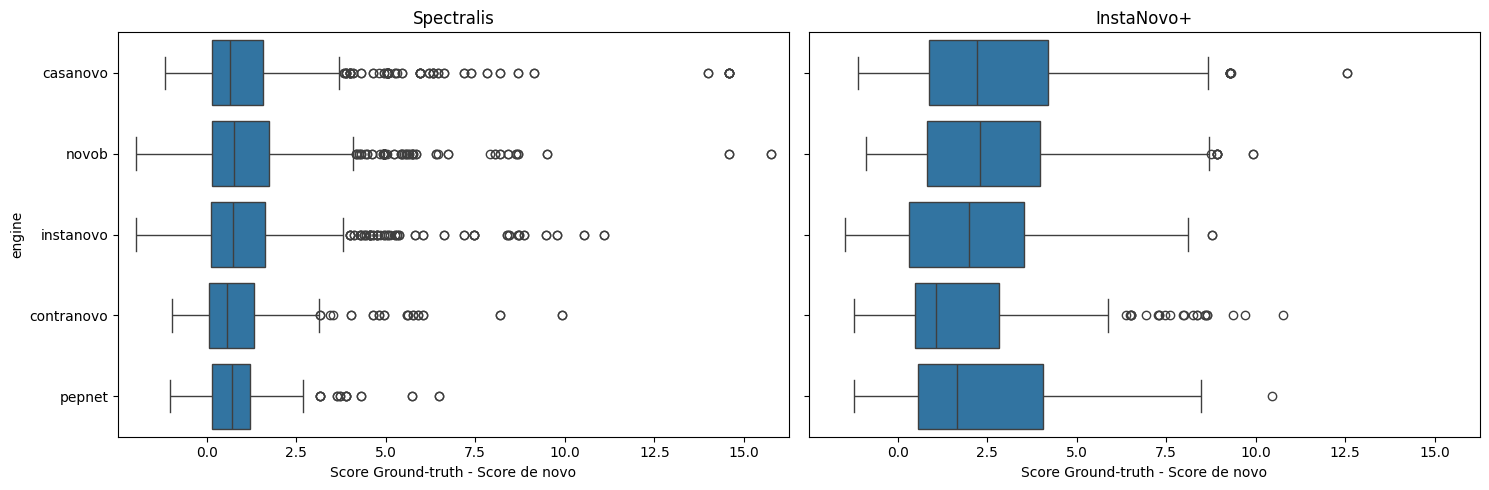

In [140]:
plot_boxplot_score_diff(
    df=levenshtein_df,
    refinement_type='correct-perturbed',
    score_label='ms2rescore_diff_gt_refinement'
)

## 4.4 Correctly refined sequences

In [115]:
levenshtein_df.columns

Index(['type', 'engine', 'refiner', 'levenshtein_candidate',
       'levenshtein_refinement', 'levenshtein_candidate_refinement', 'changes',
       'ms2rescore_diff', 'ms2rescore_diff_candidate_refinement',
       'ms2rescore_diff_gt_refinement',
       'diff_levenshtein_candidate_refinement'],
      dtype='object')

Text(0.5, 1.0, 'InstaNovo+')

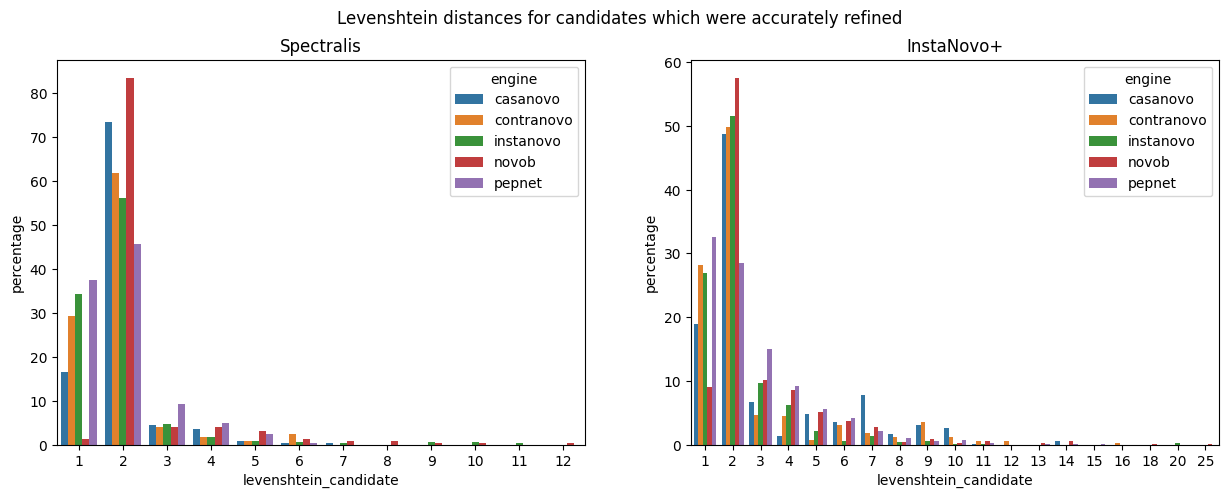

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# sns.countplot(
#     levenshtein_df.loc[
#         (levenshtein_df['type']=='corrected-by-refinement') & (levenshtein_df['refiner']=='Spectralis'),
#         ['engine', 'levenshtein_candidate']
#     ],
#     x='levenshtein_candidate',
#     hue='engine',
#     ax=ax[0]
# )
# sns.countplot(
#     levenshtein_df.loc[
#         (levenshtein_df['type']=='corrected-by-refinement') & (levenshtein_df['refiner']=='InstaNovo+'),
#         ['engine', 'levenshtein_candidate']
#     ],
#     x='levenshtein_candidate',
#     hue='engine',
#     ax=ax[1]
# )

spectralis_df = levenshtein_df.loc[
    (levenshtein_df['type'] == 'corrected-by-refinement') & (levenshtein_df['refiner'] == 'Spectralis'),
    ['engine', 'levenshtein_candidate']
]
spectralis_normalized = (
    spectralis_df
    .groupby(['engine', 'levenshtein_candidate'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

# Filter and normalize data for 'InstaNovo+'
instanovo_df = levenshtein_df.loc[
    (levenshtein_df['type'] == 'corrected-by-refinement') & (levenshtein_df['refiner'] == 'InstaNovo+'),
    ['engine', 'levenshtein_candidate']
]
instanovo_normalized = (
    instanovo_df
    .groupby(['engine', 'levenshtein_candidate'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

# Create the first plot for 'Spectralis'
sns.barplot(
    data=spectralis_normalized,
    x='levenshtein_candidate',
    y='percentage',
    hue='engine',
    ax=ax[0]
)

# Create the second plot for 'InstaNovo+'
sns.barplot(
    data=instanovo_normalized,
    x='levenshtein_candidate',
    y='percentage',
    hue='engine',
    ax=ax[1]
)

fig.suptitle('Levenshtein distances for candidates which were accurately refined')
ax[0].set_title('Spectralis')
ax[1].set_title('InstaNovo+')

In [120]:
levenshtein_df.columns

Index(['type', 'engine', 'refiner', 'levenshtein_candidate',
       'levenshtein_refinement', 'levenshtein_candidate_refinement', 'changes',
       'ms2rescore_diff', 'ms2rescore_diff_candidate_refinement',
       'ms2rescore_diff_gt_refinement',
       'diff_levenshtein_candidate_refinement'],
      dtype='object')

In [125]:
levenshtein_df.columns

Index(['type', 'engine', 'refiner', 'levenshtein_candidate',
       'levenshtein_refinement', 'levenshtein_candidate_refinement', 'changes',
       'ms2rescore_diff_candidate_refinement', 'ms2rescore_diff_gt_refinement',
       'ms2rescore_diff_gt_candidate'],
      dtype='object')

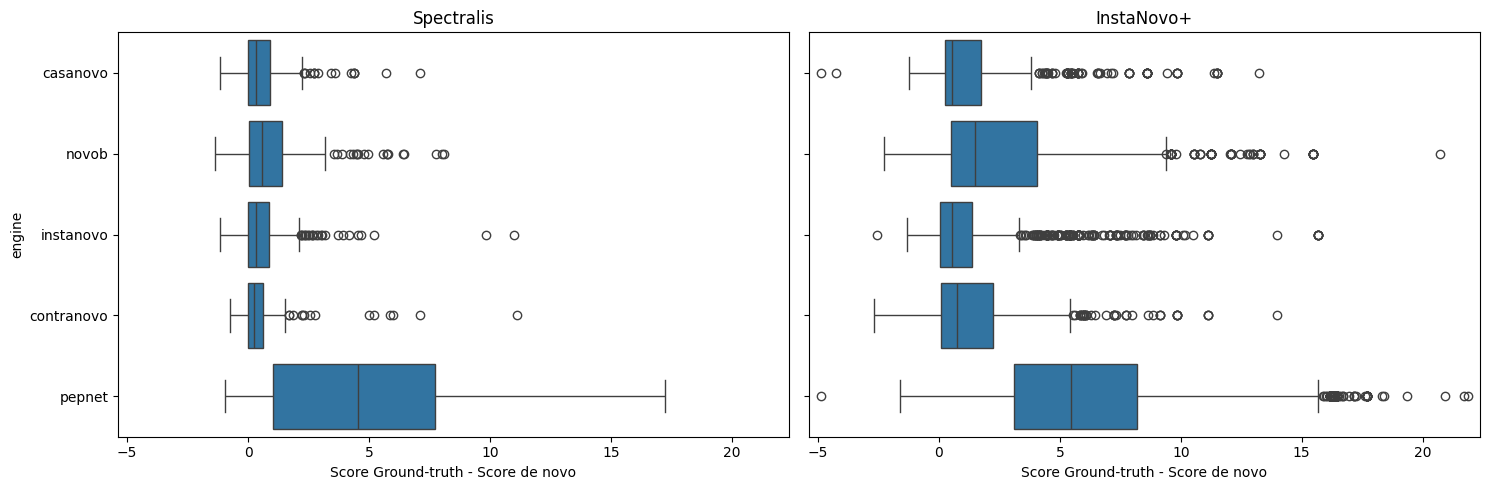

In [141]:
plot_boxplot_score_diff(
    df=levenshtein_df,
    refinement_type='corrected-by-refinement',
    score_label='ms2rescore_diff_gt_candidate'
)

## 4.5 Wrong sequence perturbed to another wrong sequence

In [97]:
levenshtein_df['diff_levenshtein_candidate_refinement'] = levenshtein_df.apply(
    lambda x: x['levenshtein_candidate'] - x['levenshtein_refinement'],
    axis=1
)

Text(0.5, 1.0, 'InstaNovo+')

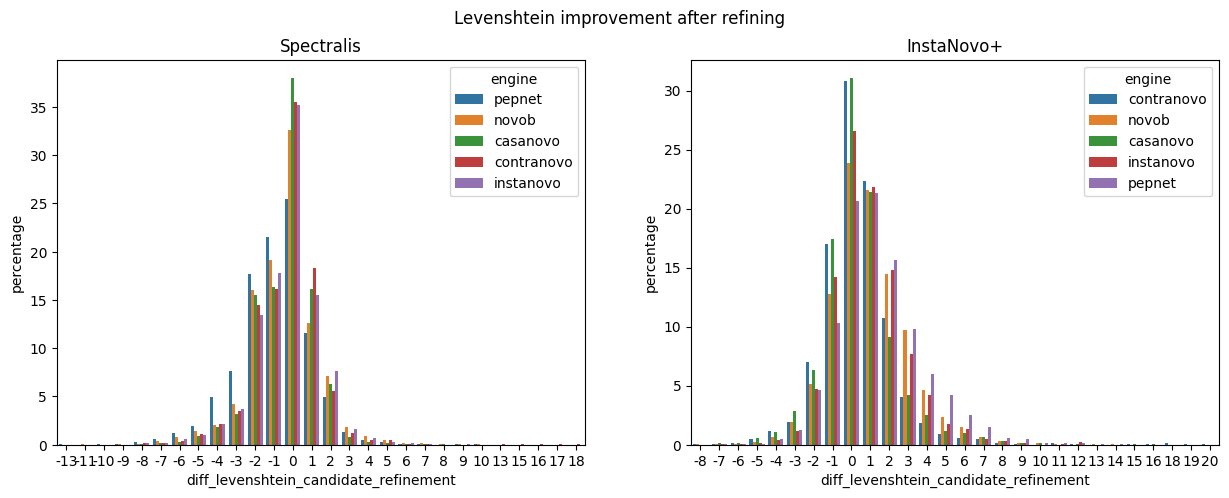

In [111]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# sns.countplot(
#     levenshtein_df.loc[
#         (levenshtein_df['type']=='wrong-wrong') & (levenshtein_df['refiner']=='Spectralis'),
#         ['engine', 'diff_levenshtein_candidate_refinement']
#     ],
#     x='diff_levenshtein_candidate_refinement',
#     hue='engine',
#     ax=ax[0]
# )
# sns.countplot(
#     levenshtein_df.loc[
#         (levenshtein_df['type']=='wrong-wrong') & (levenshtein_df['refiner']=='InstaNovo+'),
#         ['engine', 'diff_levenshtein_candidate_refinement']
#     ],
#     x='diff_levenshtein_candidate_refinement',
#     hue='engine',
#     ax=ax[1]
# )

# Filter and normalize data for 'Spectralis'
spectralis_df = levenshtein_df.loc[
    (levenshtein_df['type'] == 'wrong-wrong') & (levenshtein_df['refiner'] == 'Spectralis'),
    ['engine', 'diff_levenshtein_candidate_refinement']
]
spectralis_normalized = (
    spectralis_df
    .groupby(['engine', 'diff_levenshtein_candidate_refinement'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

# Filter and normalize data for 'InstaNovo+'
instanovo_df = levenshtein_df.loc[
    (levenshtein_df['type'] == 'wrong-wrong') & (levenshtein_df['refiner'] == 'InstaNovo+'),
    ['engine', 'diff_levenshtein_candidate_refinement']
]
instanovo_normalized = (
    instanovo_df
    .groupby(['engine', 'diff_levenshtein_candidate_refinement'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

# Create the first plot for 'Spectralis'
sns.barplot(
    data=spectralis_normalized,
    x='diff_levenshtein_candidate_refinement',
    y='percentage',
    hue='engine',
    ax=ax[0]
)

# Create the second plot for 'InstaNovo+'
sns.barplot(
    data=instanovo_normalized,
    x='diff_levenshtein_candidate_refinement',
    y='percentage',
    hue='engine',
    ax=ax[1]
)

fig.suptitle('Levenshtein improvement after refining')
ax[0].set_title('Spectralis')
ax[1].set_title('InstaNovo+')

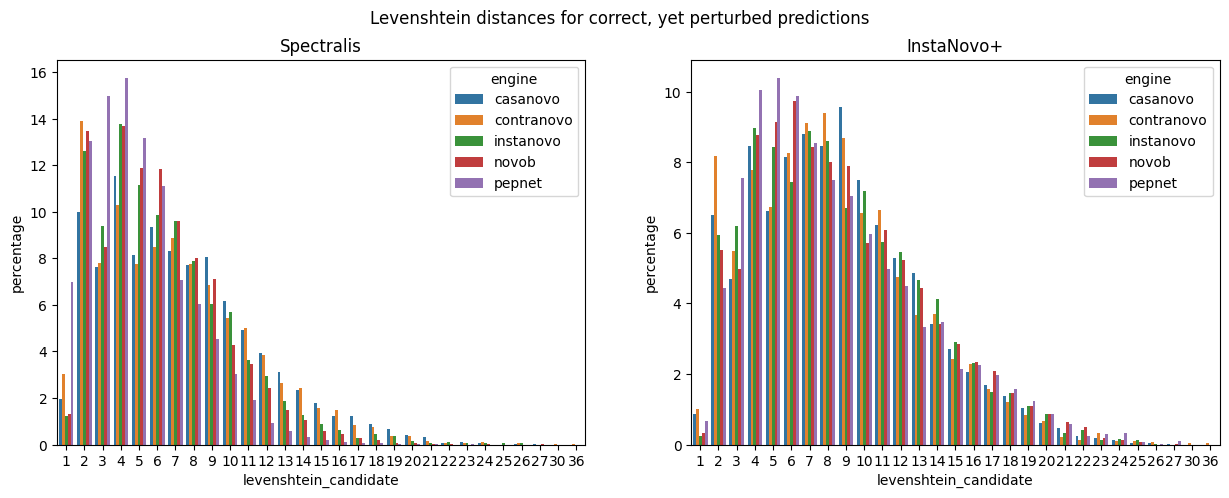

: 

In [161]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

# Filter and normalize data for 'Spectralis'
spectralis_df = levenshtein_df.loc[
    (levenshtein_df['type'] == 'wrong-wrong') & (levenshtein_df['refiner'] == 'Spectralis'),
    ['engine', 'levenshtein_candidate']
]
spectralis_normalized = (
    spectralis_df
    .groupby(['engine', 'levenshtein_candidate'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

# Filter and normalize data for 'InstaNovo+'
instanovo_df = levenshtein_df.loc[
    (levenshtein_df['type'] == 'wrong-wrong') & (levenshtein_df['refiner'] == 'InstaNovo+'),
    ['engine', 'levenshtein_candidate']
]
instanovo_normalized = (
    instanovo_df
    .groupby(['engine', 'levenshtein_candidate'])
    .size()
    .groupby(level=0)
    .apply(lambda x: x / x.sum() * 100)
    .reset_index(name='percentage')
)

# Create the first plot for 'Spectralis'
sns.barplot(
    data=spectralis_normalized,
    x='levenshtein_candidate',
    y='percentage',
    hue='engine',
    ax=ax[0]
)

# Create the second plot for 'InstaNovo+'
sns.barplot(
    data=instanovo_normalized,
    x='levenshtein_candidate',
    y='percentage',
    hue='engine',
    ax=ax[1]
)

fig.suptitle('Levenshtein distances for correct, yet perturbed predictions')
ax[0].set_title('Spectralis')
ax[1].set_title('InstaNovo+')
plt.show()

Text(0.5, 1.0, 'InstaNovo+')

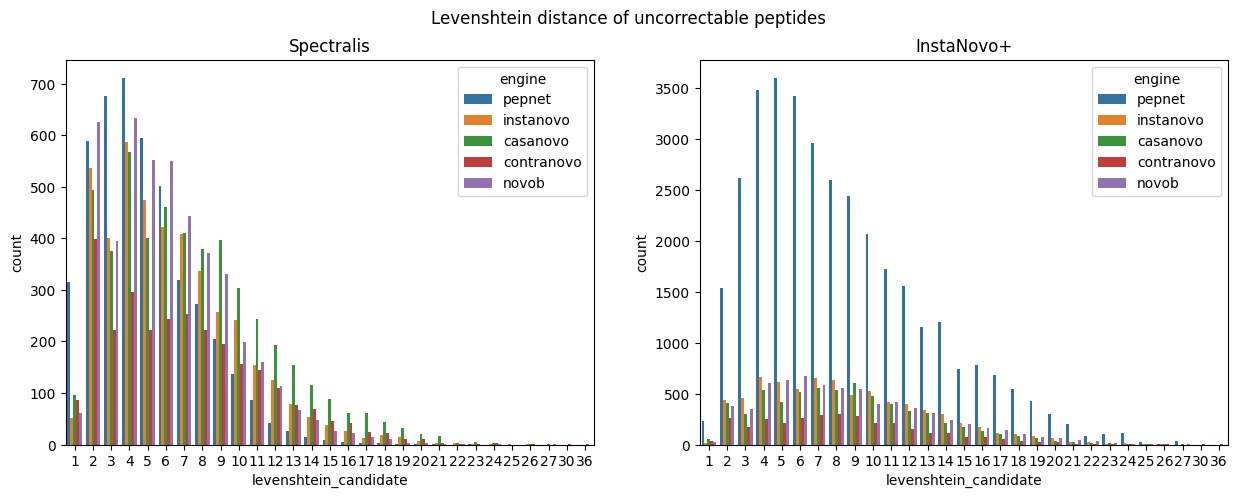

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.countplot(
    levenshtein_df.loc[
        (levenshtein_df['type']=='wrong-wrong') & (levenshtein_df['refiner']=='Spectralis'),
        ['engine', 'levenshtein_candidate']
    ],
    x='levenshtein_candidate',
    hue='engine',
    ax=ax[0]
)
sns.countplot(
    levenshtein_df.loc[
        (levenshtein_df['type']=='wrong-wrong') & (levenshtein_df['refiner']=='InstaNovo+'),
        ['engine', 'levenshtein_candidate']
    ],
    x='levenshtein_candidate',
    hue='engine',
    ax=ax[1]
)

fig.suptitle('Levenshtein distance of uncorrectable peptides')
ax[0].set_title('Spectralis')
ax[1].set_title('InstaNovo+')

In [127]:
levenshtein_df.columns

Index(['type', 'engine', 'refiner', 'levenshtein_candidate',
       'levenshtein_refinement', 'levenshtein_candidate_refinement', 'changes',
       'ms2rescore_diff_candidate_refinement', 'ms2rescore_diff_gt_refinement',
       'ms2rescore_diff_gt_candidate'],
      dtype='object')

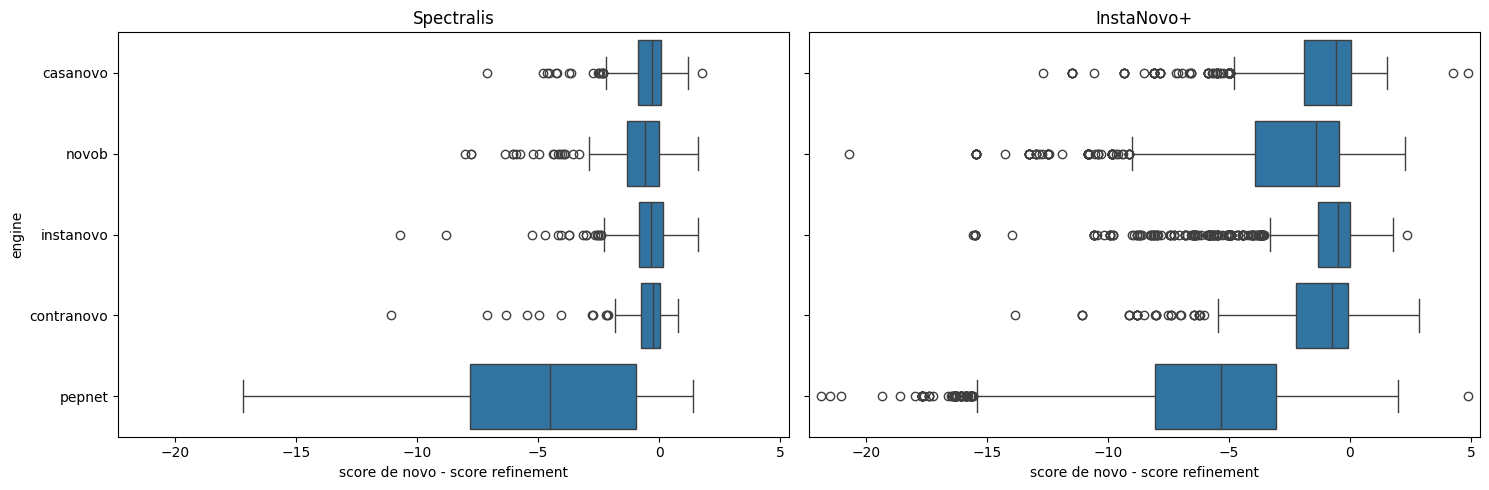

In [ ]:
plot_boxplot_score_diff(
    df=levenshtein_df,
    refinement_type='corrected-by-refinement',
    score_label='ms2rescore_diff_candidate_refinement',
    xlabel='score de novo - score refinement'
)

Text(0.5, 0, 'score Ground-truth - score de novo')

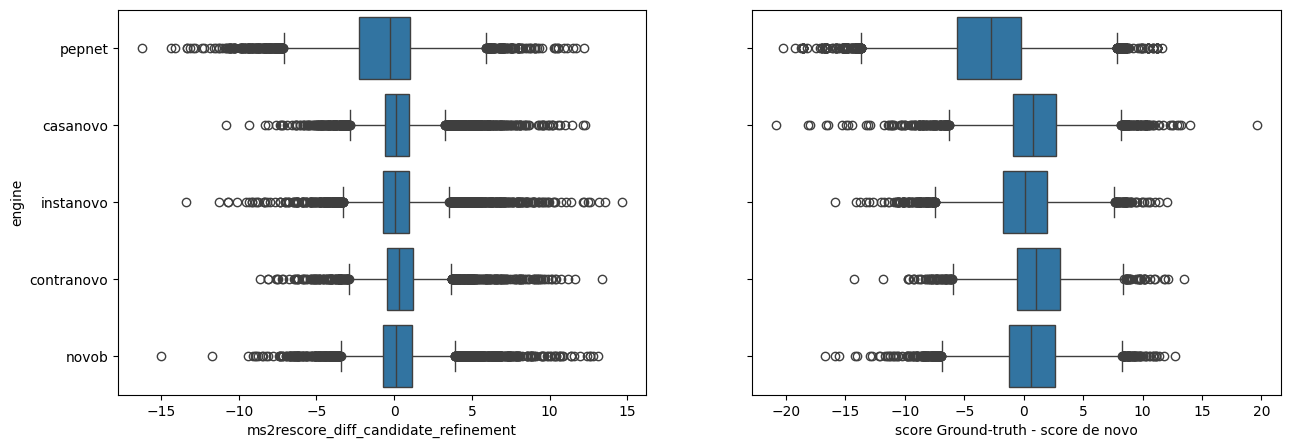

In [143]:
# Ground-truth is still lot of times better than the candidate. The algorihtm, just doesnt know what to do
fig, ax = plt.subplots(1,2, figsize=(15,5), sharey=True)
sns.boxplot(
    levenshtein_df.loc[
        (levenshtein_df['type']=='wrong-wrong') & (levenshtein_df['refiner']=='Spectralis'),
        ['engine', 'ms2rescore_diff_candidate_refinement', 'ms2rescore_diff_gt_candidate']
    ],
    x='ms2rescore_diff_candidate_refinement',
    y='engine',
    ax=ax[0]
)
sns.boxplot(
    levenshtein_df.loc[
        (levenshtein_df['type']=='wrong-wrong') & (levenshtein_df['refiner']=='InstaNovo+'),
        ['engine', 'ms2rescore_diff_candidate_refinement', 'ms2rescore_diff_gt_candidate']
    ],
    x='ms2rescore_diff_candidate_refinement',
    y='engine',
    ax=ax[1]
)

plt.xlabel('score Ground-truth - score de novo')